# Purpose:
- To see if whisker feature angle discrimination affects clustering index
    - During naïve, learning, and expert sessions
## Hypothesis:
- Clustering index variability during naïve sessions are due to the variability in angle discriminability from sensory inputs (whisker features)
    - When sensory inputs discriminate angles better, S1 activity discriminates angles better.
## Method:
- Use LDA to discriminate the angles from whisker features.
- Look at the correlation between LDA results and clustering index
    - From different phases of learning
- Whisker feature dataframes were made by data_processing\240328_build_whisker_feature_dataframe_dev.ipynb
    - saved at E:\TPM\JK\h5\results\touch_whisker_features

# Conclusion:
- LDA performs near-perfectly from the beginning.
- Logistic regression is better than LDA (less assumption).
- Check feature importance.
- Also check feature encoding.

In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
import utils.clustering_index as ci
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import utils.lda_angle_discrim as lda_angle

base_dir = Path(r'E:\TPM\JK\h5')
results_dir = base_dir / 'results'
wf_dir = results_dir / 'touch_whisker_features'
pr_dir = results_dir / 'pop_responses' / 'touch_before_answer'

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [2]:
mouse = 25
volume = 1
sessions = [int(s) for s in training_volume_df.query('mouse==@mouse and volume==@volume').session.unique()]
session = sessions[0]
session

1

In [10]:
wf_df = pd.read_pickle(wf_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl')

In [4]:
pr_data = np.load(pr_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy',
                   allow_pickle=True).item()

In [8]:
pr_data.keys()

dict_keys(['per_touch_response_xr_fit', 'per_touch_response_df', 'per_touch_response_xr'])

In [8]:
ptr_xr_fit = pr_data['per_touch_response_xr_fit']
ptr_df = pr_data['per_touch_response_df']
ptr_df.set_index('trialNum', inplace=True, drop=True)
trialNums = ptr_xr_fit.trialNum.values

In [16]:
wf_df_volume = wf_df.query("trialNum in @trialNums")
wf_df_volume_before_answer = wf_df_volume.groupby('trialNum').apply(
    lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
        drop=True)

In [23]:
wf_before_answer_mean = wf_df_volume_before_answer.groupby('trialNum').mean()
wf_before_answer_mean['touch_count'] = wf_df_volume_before_answer.groupby('trialNum').size()
merge_columns = ['pole_angle', 'correct', 'wrong', 'miss']
for column_name in merge_columns:
    wf_before_answer_mean[column_name] = ptr_df.loc[wf_before_answer_mean.index, column_name]


In [24]:
wf_before_answer_mean

,touch_onset_time,touch_offset_time,answer_lick_time,touch_duration,slide_distance,theta_onset,phi_onset,kappaH_onset,kappaV_onset,arcLength_onset,delta_theta,delta_kappaH,delta_phi,delta_kappaV,touch_count,pole_angle,correct,wrong,miss
trialNum,,,,,,,,,,,,,,,,,,,
2,2.025768,2.043038,2.621974,0.017270,0.279083,4.193279,6.898281,0.033350,-0.056277,5.424565,2.406516,-0.013225,0.913934,0.003454,16,135,True,False,False
3,1.643572,1.653211,2.783140,0.009639,0.283127,-3.890456,6.740262,0.043779,-0.064431,5.351100,1.124263,-0.005835,-0.513035,-0.003443,11,45,False,True,False
6,2.000386,2.017414,2.690822,0.017029,0.275705,3.529633,9.393236,0.034534,-0.053225,5.530224,3.120379,-0.018829,0.384632,0.010482,10,135,True,False,False
8,2.333020,2.366911,3.529804,0.033891,0.211602,-14.499181,12.431040,0.042027,-0.068804,5.371158,1.429355,-0.006644,-0.236501,-0.001756,31,45,False,True,False
9,2.233921,2.249068,2.559641,0.015147,0.302135,-14.174824,15.729994,0.048503,-0.062629,5.316478,1.257619,-0.006224,-0.838555,-0.003522,7,45,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.967533,1.979180,2.676338,0.011647,0.432299,7.537379,11.530088,0.027613,-0.059420,5.539347,2.020751,-0.004674,2.033491,0.000534,8,135,False,True,False
245,1.890717,1.927344,2.651323,0.036628,0.587789,-10.842469,10.036871,0.033168,-0.074411,5.242415,3.563117,-0.017979,-2.116427,-0.005368,15,45,True,False,False
246,2.745470,2.755912,3.292638,0.010442,0.485008,4.018082,0.576474,0.023894,-0.074116,5.407521,2.425623,-0.009389,-2.037511,-0.003397,4,45,True,False,False


In [26]:
whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
X = wf_before_answer_mean.loc[:,whisker_feature_names].values
y = wf_before_answer_mean['pole_angle'].values

In [31]:
lda_performance = lda_angle.get_lda_accuracies(X,y)
lda_shuffled_performance = lda_angle.get_shuffle_lda_accuracies(X,y)

In [32]:
lda_performance

0.999875

In [33]:
lda_shuffled_performance

0.4838577694235589

In [62]:
def get_lda_performance_from_whisker_features(whisker_feature_df, pop_res_df,
                                            touch_window='before_answer'):
    touch_window_list = ['before_answer', 'after_answer', 'all']
    if touch_window not in touch_window_list:
        raise ValueError("touch_window should be one of 'before_answer', 'after_answer', or 'all'")
    trialNums = pop_res_df.trialNum.unique()
    wf_df_volume = whisker_feature_df.query("trialNum in @trialNums")
    if touch_window == 'before_answer':
        wf_df_volume = wf_df_volume.groupby('trialNum').apply(
        lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
            drop=True)
    elif touch_window == 'after_answer':
        wf_df_volume = wf_df_volume.groupby('trialNum').apply(
        lambda x: x.query('touch_onset_time >= answer_lick_time')).reset_index(
            drop=True)
    else:
        pass
    pop_res_df.set_index('trialNum', inplace=True, drop=True)
    wf_df_volume_mean = wf_df_volume.groupby('trialNum').mean()
    # remove rows with NaN values (very rare, but happens sometimes)
    nan_index = wf_df_volume_mean.loc[np.isnan(wf_df_volume_mean.values).any(axis=1)].index.values
    wf_df_volume_mean.drop(nan_index, inplace=True)
    assert np.isnan(wf_df_volume_mean.values).any() == False

    wf_df_volume_mean['touch_count'] = wf_df_volume.groupby('trialNum').size()
    merge_columns = ['pole_angle', 'correct', 'wrong', 'miss']
    for column_name in merge_columns:
        wf_df_volume_mean[column_name] = pop_res_df.loc[wf_df_volume_mean.index, column_name]
    whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
                            'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
                            'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
    X = wf_df_volume_mean.loc[:,whisker_feature_names].values
    y = wf_df_volume_mean['pole_angle'].values
    lda_performance = lda_angle.get_lda_accuracies(X,y)
    lda_shuffled_performance = lda_angle.get_shuffle_lda_accuracies(X,y)
    return lda_performance, lda_shuffled_performance

In [63]:

mouse = 25
volume = 1
sessions = [int(s) for s in training_volume_df.query('mouse==@mouse and volume==@volume').session.unique()]
lda_performances = []
lda_shuffled_performances = []
for session in sessions:
    whisker_feature_df = pd.read_pickle(wf_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl')
    pop_res_data = np.load(pr_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy',
                   allow_pickle=True).item()
    pop_res_df = pop_res_data['per_touch_response_df']
    lda_perfs = get_lda_performance_from_whisker_features(whisker_feature_df, pop_res_df)
    lda_performances.append(lda_perfs[0])
    lda_shuffled_performances.append(lda_perfs[1])

In [58]:
lda_performances

[1.0,
 0.9909832108680793,
 0.9821511437908496,
 0.9602738095238095,
 0.9623115384615386,
 0.9695923790140207,
 0.9592017416545718,
 0.9610801393728222]

In [59]:
lda_shuffled_performances

[0.48694172932330837,
 0.6535305023923444,
 0.5026775210084033,
 0.5048710317460317,
 0.4891307692307692,
 0.5164105608322026,
 0.49644684325108857,
 0.4863240418118467]

Text(0.5, 1.0, 'Shuffled')

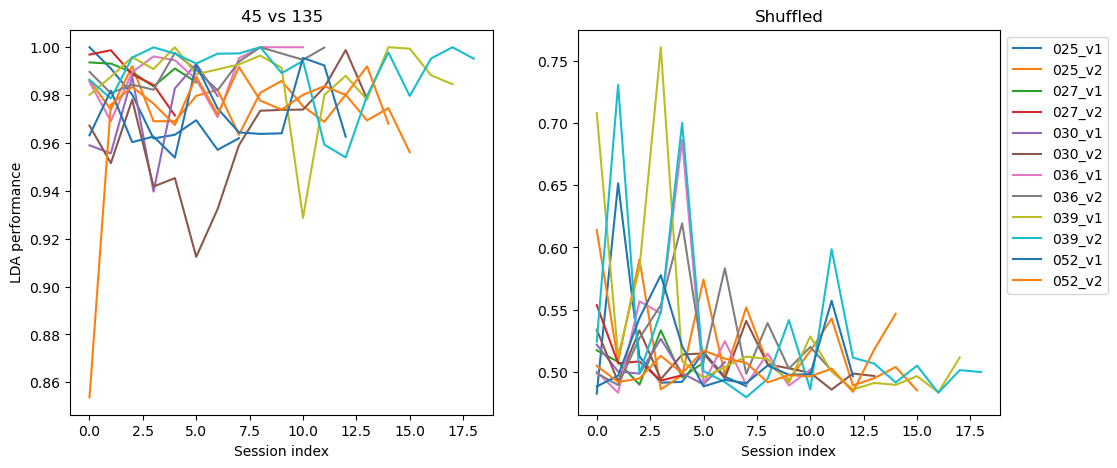

In [64]:
matplotlib.style.use('default')
fig, ax = plt.subplots(1,2,figsize=(12,5))
for mouse in mice:
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query('mouse==@mouse and volume==@volume').session.unique()]
        lda_performances = []
        lda_shuffled_performances = []
        for session in sessions:
            whisker_feature_df = pd.read_pickle(wf_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl')
            pop_res_data = np.load(pr_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy',
                        allow_pickle=True).item()
            pop_res_df = pop_res_data['per_touch_response_df']
            lda_perfs = get_lda_performance_from_whisker_features(whisker_feature_df, pop_res_df)
            lda_performances.append(lda_perfs[0])
            lda_shuffled_performances.append(lda_perfs[1])
        ax[0].plot(range(len(sessions)), lda_performances, label=f'{mouse:03}_v{volume}')
        ax[1].plot(range(len(sessions)), lda_shuffled_performances, label=f'{mouse:03}_v{volume}')
for i in range(2):
    ax[i].set_xlabel('Session index')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[0].set_ylabel('LDA performance')
ax[0].set_title('45 vs 135')
ax[1].set_title('Shuffled')

# Debugging

In [54]:
session

1

In [60]:
mouse = 25
volume = 1
session = 1
whisker_feature_df = pd.read_pickle(wf_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl')
pop_res_data = np.load(pr_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy',
                allow_pickle=True).item()
pop_res_df = pop_res_data['per_touch_response_df']

In [61]:
trialNums = pop_res_df.trialNum.unique()
wf_df_volume = whisker_feature_df.query("trialNum in @trialNums")
wf_df_volume = wf_df_volume.groupby('trialNum').apply(
    lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
        drop=True)

pop_res_df.set_index('trialNum', inplace=True, drop=True)
wf_df_volume_mean = wf_df_volume.groupby('trialNum').mean()

nan_index = wf_df_volume_mean.loc[np.isnan(wf_df_volume_mean.values).any(axis=1)].index.values
wf_df_volume_mean.drop(nan_index, inplace=True)
assert np.isnan(wf_df_volume_mean.values).any() == False

wf_df_volume_mean['touch_count'] = wf_df_volume.groupby('trialNum').size()
merge_columns = ['pole_angle', 'correct', 'wrong', 'miss']
for column_name in merge_columns:
    wf_df_volume_mean[column_name] = pop_res_df.loc[wf_df_volume_mean.index, column_name]
whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
                        'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
                        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
X = wf_df_volume_mean.loc[:,whisker_feature_names].values
y = wf_df_volume_mean['pole_angle'].values
lda_performance = lda_angle.get_lda_accuracies(X,y)
lda_shuffled_performance = lda_angle.get_shuffle_lda_accuracies(X,y)

In [44]:
lda_performance

0.989790458474669

In [16]:
w_dir = Path(r'E:\TPM\JK\WhiskerVideo')
session_name = f'JK{mouse:03}S{session:02}'
whisker_pkl_fn = w_dir / session_name / f'{session_name}_whisker.pkl'
whisker_df = pd.read_pickle(whisker_pkl_fn)
whisker_df.query('trialNum==106')[['arcLength']]

,arcLength
trialNum,
106,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [5]:
from sklearn.metrics import accuracy_score

num_split=4
num_repeat=100
all_mean_accuracy = []
for ri in range(num_repeat):
    splits_inds = lda_angle.stratify_random_split(np.arange(len(y)), y, num_splits=num_split)
    num_splits = len(splits_inds)
    accuracies = []
    for si in range(num_splits):
        test_inds = splits_inds[si]
        train_inds = np.setdiff1d(np.arange(len(y)), test_inds)
        X_train = X[train_inds,:]
        y_train = y[train_inds]
        X_test = X[test_inds.astype(int),:]
        y_test = y[test_inds.astype(int)]
        lda = LDA()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    all_mean_accuracy.append(accuracy)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [8]:
X_train.max()

nan

In [7]:
y_train


array([ 45, 135, 135,  45,  45,  45,  45, 135, 135,  45, 135, 135,  45,
       135, 135,  45,  45, 135, 135,  45, 135,  45,  45, 135,  45,  45,
        45,  45, 135, 135, 135,  45, 135,  45, 135,  45,  45, 135,  45,
       135, 135,  45, 135,  45, 135,  45,  45, 135,  45,  45,  45, 135,
       135,  45,  45,  45,  45, 135, 135,  45,  45,  45, 135,  45,  45,
        45, 135, 135,  45, 135,  45, 135, 135,  45, 135, 135,  45, 135,
       135, 135,  45,  45, 135, 135, 135,  45, 135, 135, 135,  45, 135,
        45, 135, 135, 135, 135,  45, 135, 135,  45, 135,  45,  45,  45,
       135,  45,  45, 135,  45, 135, 135,  45,  45], dtype=uint16)